# Imports and Materials

In [1]:
import gdsfactory as gf
import numpy as np
import pmag as pm
import tidy3d as td
from jmaps.journey import *
from jmaps.paths import GDS_Tidy3DPath
import matplotlib.pyplot as plt
import gplugins.tidy3d as gt
import gplugins as gp
from tidy3d.plugins.resonance import ResonanceFinder
material_list = ['diamond', 'nitride', 'oxide']
if 'mats' in dir() and np.all([m in mats for m in material_list]):
    print("mats already defined")
else:
    mats = pm.materials.init_materials(material_list, plot=False)

materials_env = JEnv('materials', {
    'material_list' : JSet(material_list),
})

Initializing diamond material
Initializing nitride material
Initializing oxide material


# Pipeline Tools

# Journey

## Journey init

In [ ]:
##################################################### GDS Device creation environments #####################################################
half_hybrid_env = JEnv('half_hybrid', {
    'left_periods' :    JSet(0),
    'right_periods' :   JSet(60),
})
full_hybrid_env = JEnv('full_hybrid', {
    'left_periods' :    JSet(60),
    'right_periods' :   JSet(60),
})
hybrid_env = JEnv('hybrid', {
    "a1" :              JVar(0.170*2), # central grating pitch
    "a2" :              JVar(0.0*2), # adiabatic taper pitch change
    "a3" :              JVar(20), # Number of periods to reach final pitch
    "a4" :              JSet(0.150*2), # SiN thickness
    "a5" :              JSet(0.5), # SiN duty cycle
    "b1" :              JVar(0.340*2), # diamond waveguide width
    "b4" :              JVar(0.100*2), # diamond waveguide height
    "center_over_rib" : JSet(True),
    "rib_length" :      JSet(6),
    "left_padding" :    JSet(4),
    "right_padding" :   JSet(4)
})

##################################################### Custom FDTD environments #####################################################
full_hybrid_fdtd_env = JEnv('full_hybrid_fdtd', {
    'inputs':      JSet({'o1': {
                        'modes': ['dipole_Ey'],
                        'amps': [1],
                        'phases': [0]
                        }
                   }),
    'outputs':     JSet({}),
    'z_monitor':   JSet('nitride'),
    'z_freq':      JSet(None),
    'z_thickness': JSet(0)
})

##################################################### Component creation environments #####################################################
layer_kwargs = {
    "oxide_thickness": 5,
    "nitride_thickness": hybrid_env['a4'].value,
    "diamond_thickness": hybrid_env['b4'].value
}
pdk = pm.pdks.get_hybrid_cav_pdk()
pdk.activate()
layer_stack = pm.layers.get_hybrid_layer_stack(**layer_kwargs)

component_env = JEnv('component', {
    'material_mapping': JOpt(mats),
    'pad_xy_inner':     JSet(0),
    'pad_xy_outer':     JSet(0),
    'pad_z_inner':      JSet(0),
    'pad_z_outer':      JSet(0),
    'extend_ports':     JSet(0),
    'port_offset':      JSet(0),
    'layer_stack':      JOpt(layer_stack),
})

##################################################### Modeler creation environments #####################################################
modeler_env = JEnv('modeler', {
    'center_z': JSet("nitride"),
    'port_size_mult': JSet((6, 4)),
    'sim_size_z': JSet(2.5),
    'crop_x': JSet(3.5),
    'crop_y': JSet(1.5),
    'bandwidth': JSet(0.2),
    'num_freqs': JSet(101),
    'symmetry': JSet((0,-1,0)),
    'boundary_spec': JOpt(td.BoundarySpec(
                        x=td.Boundary(minus=td.Absorber(), plus=td.Absorber()),
                        y=td.Boundary(minus=td.PML(), plus=td.PML()),
                        z=td.Boundary(minus=td.PML(), plus=td.PML())))
})
# Wavelength dependent modeler environments
short_env = JEnv('short_wavelength', {
    'wavelength' :       JVar(0.3*2),
    'min_steps_per_wvl': JSet(15),
    'run_time':          JSet(1.4e-12),
    'run_only':          JSet([('o1', 0)]),
})
long_env = JEnv('long_wavelength', {
    'wavelength' :       JVar(0.6195*2),
    'min_steps_per_wvl': JSet(25),
    'run_time':          JSet(1.7e-12),
    'run_only':          JSet([('o1', 0)]),
})

##################################################### Journey creation #####################################################
envs = [short_env, long_env, half_hybrid_env, full_hybrid_env, hybrid_env, component_env, modeler_env, materials_env, full_hybrid_fdtd_env]
journey = Journey('hybrid_dev', envs=envs)
print(journey)

Journey(hybrid_dev)
Environments:
   short_wavelength:
      wavelength (VAR)
      min_steps_per_wvl (SET)
      run_time (SET)
      run_only (SET)
   long_wavelength:
      wavelength (VAR)
      min_steps_per_wvl (SET)
      run_time (SET)
      run_only (SET)
   half_hybrid:
      left_periods (SET)
      right_periods (SET)
   full_hybrid:
      left_periods (SET)
      right_periods (SET)
   hybrid:
      a1 (VAR)
      a2 (VAR)
      a3 (VAR)
      a4 (SET)
      a5 (SET)
      b1 (VAR)
      b4 (VAR)
      center_over_rib (SET)
      rib_length (SET)
      left_padding (SET)
      right_padding (SET)
   component:
      material_mapping (OPT)
      pad_xy_inner (SET)
      pad_xy_outer (SET)
      pad_z_inner (SET)
      pad_z_outer (SET)
      extend_ports (SET)
      port_offset (SET)
      layer_stack (OPT)
   modeler:
      center_z (SET)
      port_size_mult (SET)
      sim_size_z (SET)
      crop_x (SET)
      crop_y (SET)
      bandwidth (SET)
      num_freqs (SET)
    

## Half Hybrid Simulation

In [10]:
class HalfHybridPath(GDS_Tidy3DPath):
    @property
    def name(self) -> str:
        """Unique name of the path"""
        return "half_hybrid_" + self.custom_modeler
    @property
    def env_names(self) -> list[str]:
        """List of required environment names"""
        return ['half_hybrid', 'hybrid', 'materials'] + super().env_names
    
    def get_component(self, envs: dict[str, JEnv]):
        return pm.devices.hybrid_cavity(**envs['half_hybrid'].get_stripped_params(), **envs['hybrid'].get_stripped_params())

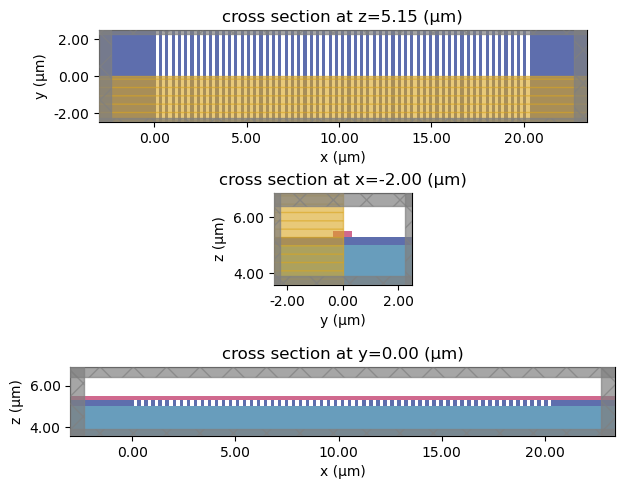

Grid size (25472160) and total time steps (45833) are within daily allowance.


Output()

16:20:59 EDT Started working on Batch containing 1 tasks.

16:21:00 EDT Maximum FlexCredit cost: 0.692 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

16:22:07 EDT Batch complete.

Output()

16:22:09 EDT WARNING: Simulation final field decay value of 0.00423 is greater  
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

Simulation saved to PosixPath('/home/floresh2/.gdsfactory/sparameters/7f8522496b0257982f4048a13424d04ba21cb55f27718ae79cfaf86cd7763373.npz')
Saved path results to cache: /orcd/home/002/floresh2/file_system/git/JourneyMAPS/src/jmaps/cache/hybrid_dev/half_hybrid_short_wavelength/29e594b5eb16d0571e9c40eb13f3075db7576e37f48e6cd88936e7ce0480d6e8.dill


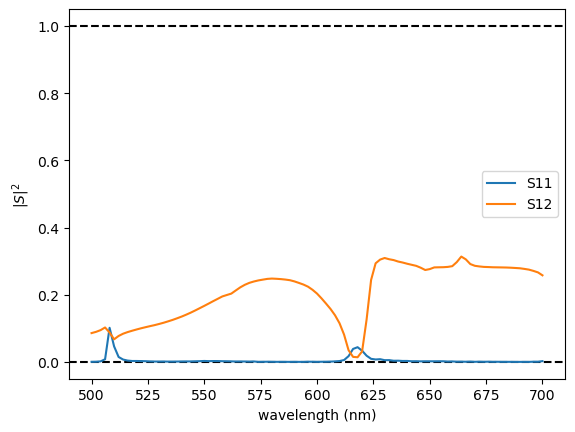

In [11]:

half_hybrid_path_short = HalfHybridPath(custom_modeler='short_wavelength')
journey.add_path(half_hybrid_path_short)
journey.validate_paths()
half_hybrid_path_short.plot_geom(journey.envs, layer_name='nitride')
# half_hybrid_path_short.plot_mode(journey.envs)
sp = journey.run_path('half_hybrid_short_wavelength', verbose=True)

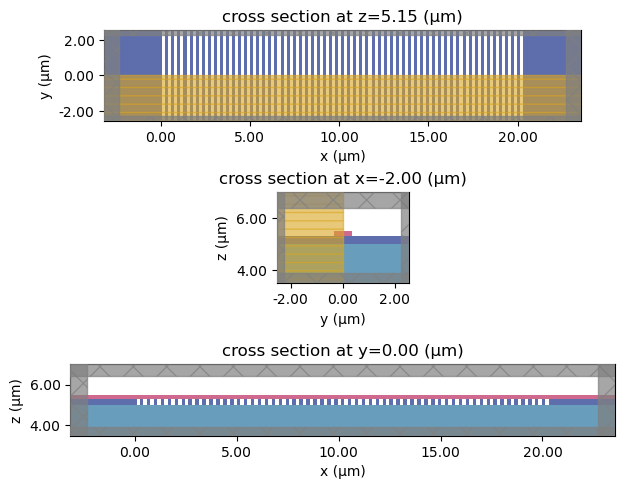

Grid size (14353338) and total time steps (44169) are within daily allowance.


Output()

16:22:31 EDT Started working on Batch containing 1 tasks.

16:22:32 EDT Maximum FlexCredit cost: 0.386 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

In [ ]:

half_hybrid_path_short = HalfHybridPath(custom_modeler='long_wavelength')
journey.add_path(half_hybrid_path_short)
half_hybrid_path_short.plot_geom(journey.envs, layer_name='nitride')
# half_hybrid_path_short.plot_mode(journey.envs)
sp = journey.run_path('half_hybrid_long_wavelength', verbose=True)

## Full Hybrid Simulation

In [6]:
class FullHybridPath(GDS_Tidy3DPath):
    @property
    def name(self) -> str:
        """Unique name of the path"""
        return self.custom_fdtd + '_' + self.custom_modeler
    @property
    def env_names(self) -> list[str]:
        """List of required environment names"""
        return ['full_hybrid', 'hybrid', 'materials'] + super().env_names
    
    def get_component(self, envs: dict[str, JEnv]):
        return pm.devices.hybrid_cavity(**envs['full_hybrid'].get_stripped_params(), **envs['hybrid'].get_stripped_params())

    def ponder(self, envs: dict[str, JEnv], data):
        fig, ax1 = plt.subplots(1, 1, tight_layout=True, figsize=(8, 4))
        ax1.plot(
            data.monitor_data["o1@dipole_Ey"].Ey.t * 1e12,
            np.real(data.monitor_data["o1@dipole_Ey"].Ey.squeeze()),
        )
        ax1.set_title("FieldTimeMonitor data")
        ax1.set_xlabel("time (ps)")
        ax1.set_ylabel("Real{Ey}")
        plt.show()

        wl_min, wl_max = envs[self.custom_modeler]['wavelength']-envs['modeler']['bandwidth']/2, envs[self.custom_modeler]['wavelength']+envs['modeler']['bandwidth']/2
        fmin, fmax = td.C_0 / wl_max, td.C_0 / wl_min
        resonance_finder = ResonanceFinder(freq_window=(fmin, fmax))
        resonance_data = resonance_finder.run(signals=data['o1@dipole_Ey'])
        print(resonance_data.to_dataframe())

### Long Wavelength

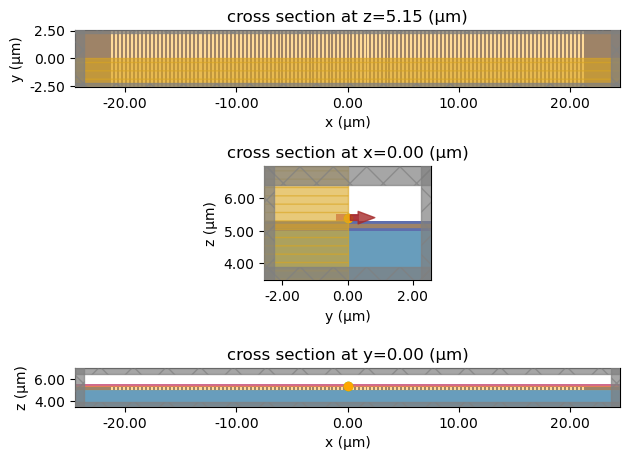

Grid size (26282952) and total time steps (44167) are within daily allowance.
Loaded path results from cache: /orcd/home/002/floresh2/file_system/git/JourneyMAPS/src/jmaps/cache/hybrid_dev/full_hybrid_fdtd_long_wavelength/0435cb0273d9a0c62d9c04fa46d4774c946690b1b08816c61213698b70925ec7.dill


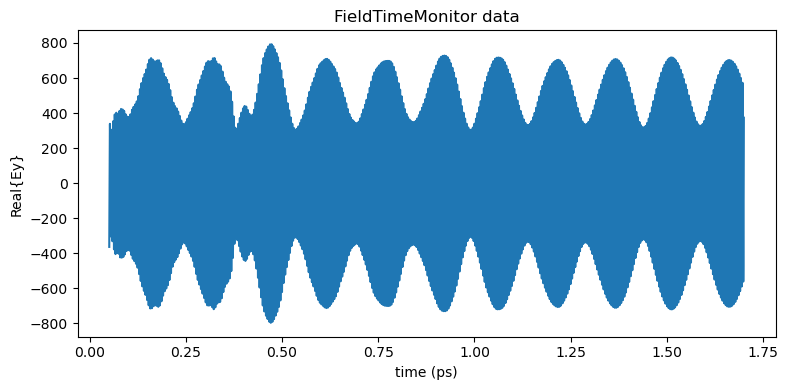

                     decay              Q   amplitude     phase     error
freq                                                                     
2.219728e+14  2.966732e+12     235.055979   14.475593  0.410244  0.028842
2.244964e+14  3.117465e+12     226.233907   19.007004 -0.587132  0.033093
2.270811e+14  2.947861e+12     242.004725   24.413362 -1.376354  0.037156
2.340953e+14  5.624766e+11    1307.489225   12.452956 -1.251944  0.016444
2.360559e+14 -1.260728e+10  -58822.464540   93.583627 -2.420920  0.005150
2.427473e+14  5.292254e+09  144099.878753  261.518493  2.515558  0.004505
2.553378e+14  3.648364e+13      21.987045   69.229020 -0.787894  0.154003


In [7]:
full_hybrid_path_long = FullHybridPath(custom_modeler='long_wavelength', custom_fdtd='full_hybrid_fdtd')
journey.add_path(full_hybrid_path_long)
journey.validate_paths()
full_hybrid_path_long.plot_geom(journey.envs, layer_name='nitride')
# half_hybrid_path_short.plot_mode(journey.envs)
data_long = journey.run_path(full_hybrid_path_long.name, verbose=True)

### Short Wavelength

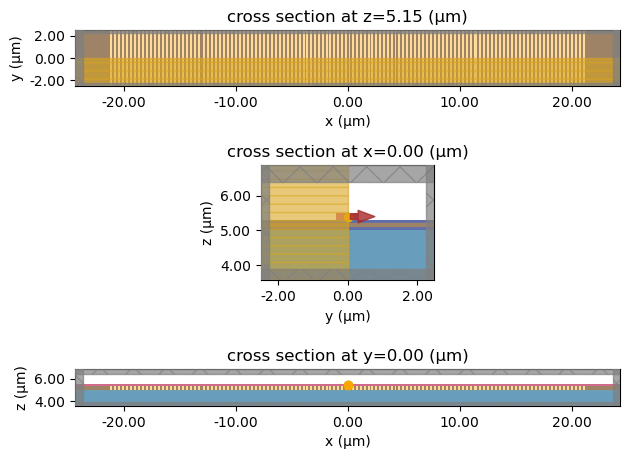

Grid size (46906440) and total time steps (45828) are within daily allowance.


16:17:33 EDT Created task 'full_hybrid_fdtd_short_wavelength' with task_id      
             'fdve-1cf30b7f-f5ca-4565-9bbf-e9640223ba06' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=291622;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1cf30b7f-f5ca-4565-9bbf-e9640223ba06\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=745371;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1cf30b7f-f5ca-4565-9bbf-e9640223ba06\taskId]8;;\]8;id=291622;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1cf30b7f-f5ca-4565-9bbf-e9640223ba06\=]8;;\]8;id=19876;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1cf30b7f-f5ca-4565-9bbf-e9640223ba06\fdve]8;;\]8;id=291622;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1cf30b7f-f5ca-4565-9bbf-e9640223ba06\-1cf30b7f-f5c]8;;\
             ]8;id=291622;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1cf30b7f-f5ca-4565-9bbf-e9640223ba06\a-4565-9bbf-e9640223ba06']8;;\.

             Task folder: ]8;id=77717;https://tidy3d.simulation.cloud/folders/folder-bccaf066-eccf-4061-aafb-95fe2ab09b26\'default']8;;\.

Output()

16:17:34 EDT Maximum FlexCredit cost: 1.186. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

16:17:35 EDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

16:17:43 EDT You are running this simulation for FREE. Your current plan allows 
             up to 20 free non-concurrent simulations per day (under 100.0M grid
             points and 50.0K time steps)

             starting up solver

             running solver

Output()

Output()

16:18:45 EDT status = success

16:18:47 EDT View simulation result at                                          
             ]8;id=94739;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1cf30b7f-f5ca-4565-9bbf-e9640223ba06\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=802253;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1cf30b7f-f5ca-4565-9bbf-e9640223ba06\taskId]8;;\]8;id=94739;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1cf30b7f-f5ca-4565-9bbf-e9640223ba06\=]8;;\]8;id=325648;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1cf30b7f-f5ca-4565-9bbf-e9640223ba06\fdve]8;;\]8;id=94739;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1cf30b7f-f5ca-4565-9bbf-e9640223ba06\-1cf30b7f-f5c]8;;\
             ]8;id=94739;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1cf30b7f-f5ca-4565-9bbf-e9640223ba06\a-4565-9bbf-e9640223ba06']8;;\.

Output()

16:18:53 EDT loading simulation from simulation_data.hdf5

             WARNING: Simulation final field decay value of 0.00013 is greater  
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

Saved path results to cache: /orcd/home/002/floresh2/file_system/git/JourneyMAPS/src/jmaps/cache/hybrid_dev/full_hybrid_fdtd_short_wavelength/0bf12af29817e29f2fd828cfb1c5eaed03516b295c673a16c6f43eccd1eaade9.dill


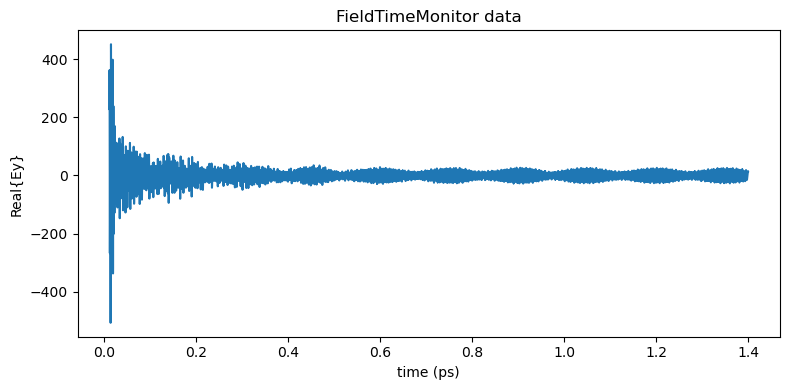

                     decay            Q   amplitude     phase     error
freq                                                                   
2.424135e+14 -6.024911e+11 -1264.025840    4.682448 -2.023434  0.057467
3.736254e+14 -4.488894e+12  -261.485048    5.565896  0.867081  0.287190
4.015086e+14 -1.482820e+12  -850.660744    1.035986  0.102773  0.150809
4.127374e+14  2.299910e+13    56.378415   28.243825 -2.064164  0.179729
4.256306e+14  7.945037e+12   168.301024    3.551929  1.498006  0.247000
4.290586e+14  1.344428e+12  1002.602961    0.267322  1.600891  0.161968
4.353880e+14 -1.581920e+12  -864.652949    0.227801 -0.902239  0.288228
4.365352e+14  6.713601e+12   204.274227    1.784069 -2.280245  0.095301
4.444437e+14  8.446533e+12   165.305836    9.998844 -1.975146  0.078052
4.466978e+14  8.832383e+12   158.886050   12.112150  1.806836  0.074099
4.629372e+14  6.940959e+12   209.533003    5.102405  2.759030  0.081824
4.981839e+14 -3.142772e+12  -497.996954    4.643895  3.115972  0

In [8]:
full_hybrid_path_short = FullHybridPath(custom_modeler='short_wavelength', custom_fdtd='full_hybrid_fdtd')
journey.add_path(full_hybrid_path_short)
journey.validate_paths()
full_hybrid_path_short.plot_geom(journey.envs, layer_name='nitride')
# half_hybrid_path_short.plot_mode(journey.envs)
data_short = journey.run_path(full_hybrid_path_short.name, verbose=True)